# 02d — Geochemistry features (USGS NGS → grid)
Fetch geochemical points from the Missouri DNR ArcGIS REST service (USGS NGS),
aggregate to the current polygon-masked grid, and save grid-aligned features.

Outputs:
- `data/processed/X_geochem.npy`  (N×K)
- `data/processed/feature_names_geochem.json`


In [5]:
# 1) Imports & config

import os, sys, json
import numpy as np
import geopandas as gpd
import joblib
from pathlib import Path

# Make 'src/' importable
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.geochem import (
    ELEMENTS_DEFAULT,
    fetch_ngs_geojson_by_bbox,
    points_to_grid_geochem_features,
)

STATE = "Missouri"
GRID_PATH = project_root / "data/processed/grid_gdf.joblib"
OUT_NPY  = project_root / "data/processed/X_geochem.npy"
OUT_JSON = project_root / "data/processed/feature_names_geochem.json"




In [6]:
# 2) Load grid & fetch points
grid = joblib.load(GRID_PATH)
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)

bbox = grid.total_bounds  # (minx, miny, maxx, maxy)
print("Grid cells:", len(grid))
print("Querying NGS within bbox:", bbox)

gdf = fetch_ngs_geojson_by_bbox(bbox, fields="*")  # or ["OBJECTID","LONGITUDE","LATITUDE"]
print("Fetched NGS points:", len(gdf))
if len(gdf) > 0:
    display(gdf.head())


Grid cells: 7646
Querying NGS within bbox: [-95.77435509  35.99560302 -89.07435509  40.64560302]
Fetched NGS points: 929
Fetched NGS points: 929


,OBJECTID,REC_NO,LABNO,LABNO2,PREV_LABNO,FLDNAM,COLL_DATE,FLDNAM_AN,DESCRIPT,AOV_CODE,...,W_NURE,Y_NURE,YB_NURE,ZN_NURE,ZR_NURE,U_NURE,NURE_METH,ZIP3,CONGDIST,geometry
0,1,5260237,BQ11-303,,,MOSH025S1,282182400000,MOSH025,NURE sample,,...,0,0,0.0,0.0,0.0,4.0,"SR1, SR2",654,2908C2,POINT (-91.44231 36.98731)
1,2,5260242,BQ11-305,,,MOSH030S1,282268800000,MOSH030,NURE sample,,...,0,0,5.0,0.0,0.0,4.0,"SR1, SR2",654,2908C2,POINT (-91.38711 36.92851)
2,3,5260192,BQ11-310,,,MORI060S1,267926400000,MORI060D,NURE sample,R1,...,0,0,0.0,0.0,0.0,4.8,"SR1, SR2",639,2908C2,POINT (-91.00821 36.55381)
3,4,5260183,BQ11-312,,,MORI051S1,267926400000,MORI051D,NURE sample,R1,...,0,0,3.0,0.0,0.0,3.2,"SR1, SR2",639,2908C2,POINT (-90.76291 36.65211)
4,5,5260234,BQ11-313,,,MOSH014S1,282009600000,MOSH014D,NURE sample,R1,...,0,0,-1.2,0.0,0.0,3.5,"SR1, SR2",654,2908C2,POINT (-91.59401 36.91181)


In [7]:
# 3) Process and aggregate geochem data
from src.geochem import process_geochem_data

X_geochem, feat_names = process_geochem_data(grid, gdf)

# 4) Save features
os.makedirs(project_root / "data/processed", exist_ok=True)
np.save(OUT_NPY, X_geochem)
with open(OUT_JSON,"w") as f:
    json.dump(feat_names, f)

print("Saved data/processed/X_geochem.npy", X_geochem.shape)
print("Saved data/processed/feature_names_geochem.json", len(feat_names), "cols")

Saved data/processed/X_geochem.npy (7646, 8)
Saved data/processed/feature_names_geochem.json 8 cols


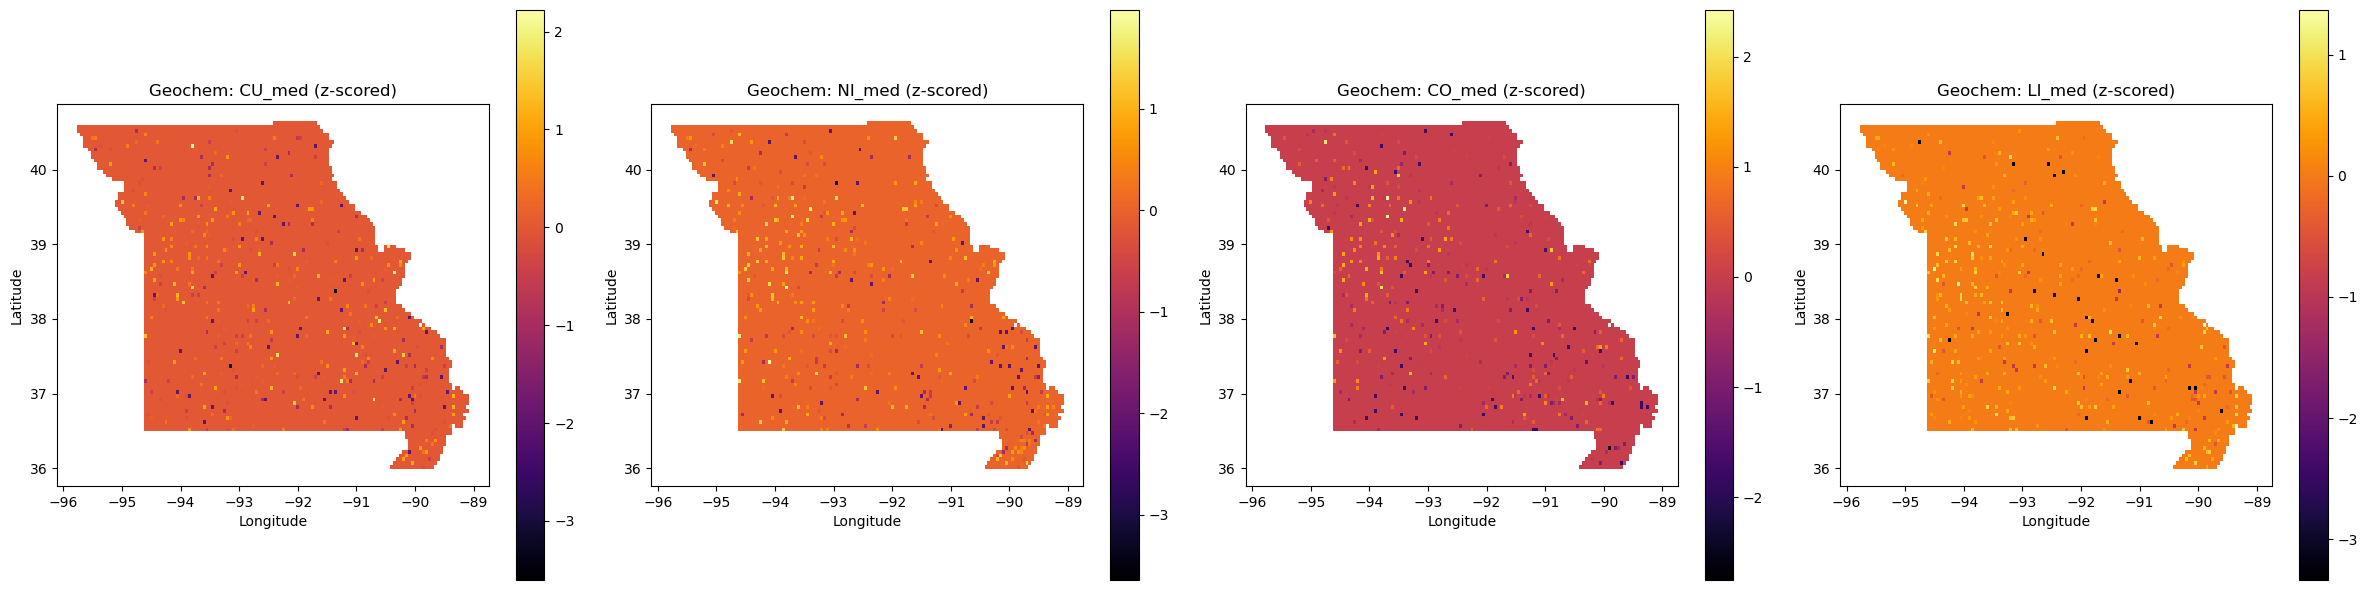

Saved figures/geochem_maps.png


In [8]:
# --- Geochemistry maps (example: CU_p90, NI_p90) ---
import json, os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs(project_root / "figures", exist_ok=True)

Xgc = np.load(project_root / "data/processed/X_geochem.npy")
with open(project_root / "data/processed/feature_names_geochem.json") as f:
    fn_gc = json.load(f)

gchem = grid.copy()
for i, name in enumerate(fn_gc):
    gchem[name] = Xgc[:, i]

def first_col(prefix):
    # return the first feature name that starts with prefix (e.g., "CU_")
    for c in fn_gc:
        if c.upper().startswith(prefix.upper()):
            return c
    return None

cu_col = first_col("CU_")
ni_col = first_col("NI_")
co_col = first_col("CO_")
li_col = first_col("LI_")

cols_to_plot = [c for c in [cu_col, ni_col, co_col, li_col] if c is not None]
if not cols_to_plot:
    print("No CU_*/NI_* columns found in geochem features; check 02d processing.")
else:
    n = len(cols_to_plot)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, cols_to_plot):
        gchem.plot(column=col, cmap="inferno", legend=True, ax=ax)
        ax.set_title(f"Geochem: {col} (z-scored)")
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.tight_layout(); plt.savefig(project_root / "figures/geochem_maps.png", dpi=180); plt.show()
    print("Saved figures/geochem_maps.png")
